### In this notebook, I perform exploratory data analysis of features, both engineered features from notebook "1. Preprocessing.ipynb" and text features from Vectorizers
I perform EDA of the following:
- Raw text
- Outcome variable in train set
- Numerical features engineered from notebook 1
- Numerical features importances using LGBM
- Text features using vectorizers, visualise importance using LGBM

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import string
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix, hstack, vstack
from sklearn import metrics
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.parsing.preprocessing import remove_stopwords
from lightgbm import LGBMClassifier, plot_importance
import time
import seaborn as sns

In [2]:
train = pd.read_csv("datasets/preprocessed_train.csv")
test = pd.read_csv("datasets/preprocessed_test.csv")

In [3]:
train.shape, test.shape

((44459, 17), (27924, 16))

In [4]:
train.head()

,Comment,Outcome,Id,num_numbers,prop_numbers,num_words,num_punctuation,prop_punctuation,nchar,word_density,pos_tags,noun_count,verb_count,adj_count,adv_count,pron_count,lda
0,combining lindelof's and gregg lind's ideas: l...,1,15086,3,0.006897,80,51,0.117241,435,5.370370,"[('combining', 'VBG'), ('lindelof', 'NN'), (""'...",30,9,9,6,1,[0.00076923 0.00076923 0.00076923 0.00076923 0...
1,in most cases r is an interpreted language tha...,1,41061,0,0.000000,39,4,0.017094,234,5.850000,"[('in', 'IN'), ('most', 'JJS'), ('cases', 'NNS...",10,8,7,1,0,[0.00131579 0.00131579 0.00131579 0.00131579 0...
2,"i don't know r at all, but a bit of creative g...",1,34417,12,0.013423,164,49,0.054810,894,5.418182,"[('i', 'NNS'), ('do', 'VBP'), (""n't"", 'RB'), (...",49,30,14,10,4,[3.18471347e-04 3.18471350e-04 3.18471338e-04 ...
3,if you don't want to modify the list in-place ...,1,30549,12,0.021164,102,92,0.162257,567,5.504854,"[('if', 'IN'), ('you', 'PRP'), ('do', 'VBP'), ...",54,18,8,6,2,[6.57894739e-04 6.57894745e-04 6.57894738e-04 ...
4,i assume it helps if the matrix is sparse? yes...,1,8496,0,0.000000,23,14,0.084848,165,6.875000,"[('i', 'NN'), ('assume', 'VBP'), ('it', 'PRP')...",9,6,0,2,1,[0.00172414 0.00172414 0.00172414 0.00172414 0...


Text(0.5, 1.0, 'Train Set Outcome Distribution')

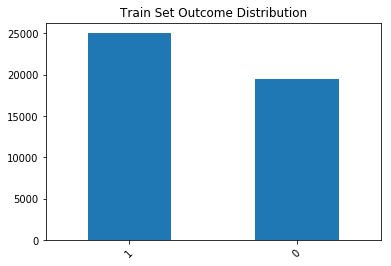

In [5]:
train.Outcome.value_counts().plot(kind="bar", rot=45)
plt.title("Train Set Outcome Distribution")

#### Here we visualise the distribution of categories, 0 and 1. We can see that there is class imbalance. Knowing that the test score we have is AUC, we cannot have class imbalance where models have a preference for predicting one outcome over the other, or this would hurt the AUC score. Importance note and why I used balanced. Had the metric been accuracy, I would have done some leaderboard probing and submitted either all 0s or 1s to gauge the distribution of the test set and adjust the class balance accordingly.

In [6]:
for i in range(10):
    print(train[train.Outcome == 1].Comment.values[i])
    print(" ")

combining lindelof's and gregg lind's ideas: last <- function(x) { tail(x, n = 1) } working at the prompt, i usually omit the "n=", i.e. tail(x, 1). unlike last from the pastecs package, head and tail (from utils) work not only on vectors but also on data frames etc., and also can return data "without first/last n elements", e.g. but.last <- function(x) { head(x, n = -1) } (note that you have to use head for this, instead of tail.)
 
in most cases r is an interpreted language that runs in a read-evaluate-print loop. there are numerous extensions to r that are written in other languages like c and fortran where speed or interfacing with native libraries is helpful.
 
i don't know r at all, but a bit of creative googling led me here: http://tolstoy.newcastle.edu.au/r/help/05/04/1919.html the key quote from there: i do not find explicit documentation for r on how to remove elements from lists, but trial and error tells me mylist[[5]] <- null will remove the 5th element and then "close up"

#### We can clearly see that there is code included in this. This is a very important feature that I was not keen on discarding. Therefore, instead of using word vectorizers, I decided to use character level embeddings that does not exclude punctuations.

Text(0.5, 1.0, 'Natural Order of Outcome')

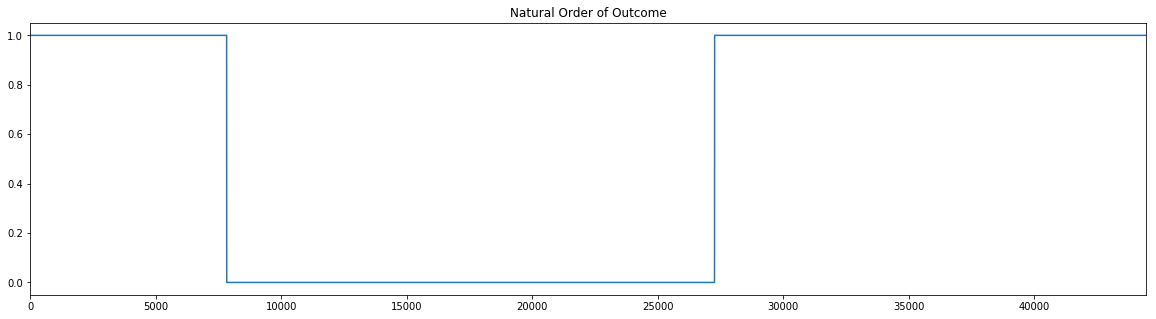

In [7]:
plt.figure(figsize=(20,5))
train.Outcome.plot()
plt.title("Natural Order of Outcome")

#### Here, we see that the train set has a natural order to it, being structured with all 1s, followed by 0s and then by 1s. If the test set has this kind of ordering to it, we would be able to exploit this somehow.

Text(0.5, 1.0, 'Id Order of Outcome')

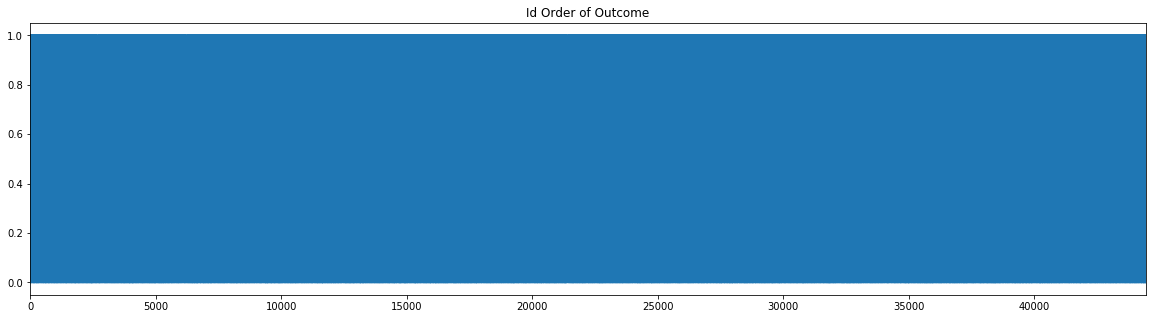

In [8]:
plt.figure(figsize=(20,5))
train.sort_values("Id").reset_index().Outcome.plot()
plt.title("Id Order of Outcome")

Text(0.5, 1.0, 'Id Order of Outcome')

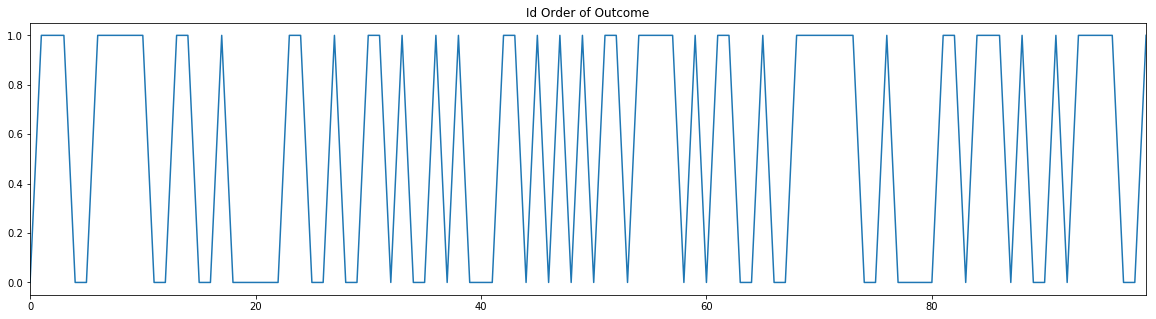

In [9]:
plt.figure(figsize=(20,5))
train.sort_values("Id").reset_index().iloc[:100].Outcome.plot()
plt.title("Id Order of Outcome")

Text(0.5, 1.0, 'Id Order of Outcome')

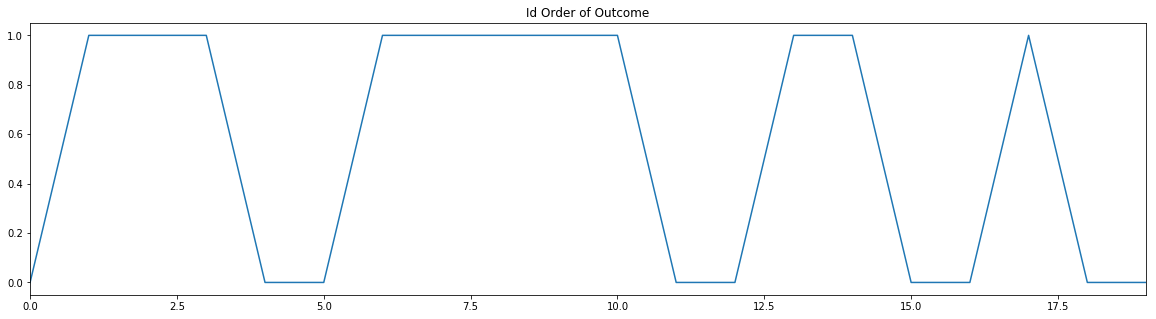

In [10]:
plt.figure(figsize=(20,5))
train.sort_values("Id").reset_index().iloc[:20].Outcome.plot()
plt.title("Id Order of Outcome")

#### I then was interested to find out how the IDs were ordered. This was not complete random ordering so there may be some logic to it. Were answers obtained from the same question thread? If so, we may be able to use topic modelling to find out which answers were similar and perhaps use the jaccard similarity of the latent dirichlet allocation of the neighbouring IDs together with the neighbouring ID's Outcome scores. However, this may introduce significant noise.

In [11]:
for i in range(10):
    print(train[train.Outcome == 1].sort_values("Id").Comment.values[i])
    print(" ")

when an object is indexed, the special method __getitem__ is looked for first in the object's class. a class itself is an object, and the class of a class is usually type. so to override __getitem__ for a class, you can redefine its metaclass (to make it a subclass of type): class metaa(type): def __getitem__(cls,val): return "it works" class a(object): __metaclass__=metaa pass print(a[0]) # it works in python3 the metaclass is specified this way: class a(object, metaclass=metaa): pass
 
apparently (having faced related 64- and 32-bit issues on os x) there is a bug in the windows installer. i stumbled across this workaround, which might help - basically, you create your own registry value hkey_local_machine\software\wow6432node\python\pythoncore\2.6\installpath and copy over the installpath value from hkey_local_machine\software\python\pythoncore\2.6\installpath. see the answer below for more details. if you do this, beware that setuptools may only install 32-bit libraries. note: the r

#### Visualising the orders, I found that neighbours had very different topics, and LDA would result in a dead end that just takes up time. However, I had another intuition that this was scrapped by user, which may be useful for the real world task in predicting if an answer is good or not.

In [12]:
train.head()

,Comment,Outcome,Id,num_numbers,prop_numbers,num_words,num_punctuation,prop_punctuation,nchar,word_density,pos_tags,noun_count,verb_count,adj_count,adv_count,pron_count,lda
0,combining lindelof's and gregg lind's ideas: l...,1,15086,3,0.006897,80,51,0.117241,435,5.370370,"[('combining', 'VBG'), ('lindelof', 'NN'), (""'...",30,9,9,6,1,[0.00076923 0.00076923 0.00076923 0.00076923 0...
1,in most cases r is an interpreted language tha...,1,41061,0,0.000000,39,4,0.017094,234,5.850000,"[('in', 'IN'), ('most', 'JJS'), ('cases', 'NNS...",10,8,7,1,0,[0.00131579 0.00131579 0.00131579 0.00131579 0...
2,"i don't know r at all, but a bit of creative g...",1,34417,12,0.013423,164,49,0.054810,894,5.418182,"[('i', 'NNS'), ('do', 'VBP'), (""n't"", 'RB'), (...",49,30,14,10,4,[3.18471347e-04 3.18471350e-04 3.18471338e-04 ...
3,if you don't want to modify the list in-place ...,1,30549,12,0.021164,102,92,0.162257,567,5.504854,"[('if', 'IN'), ('you', 'PRP'), ('do', 'VBP'), ...",54,18,8,6,2,[6.57894739e-04 6.57894745e-04 6.57894738e-04 ...
4,i assume it helps if the matrix is sparse? yes...,1,8496,0,0.000000,23,14,0.084848,165,6.875000,"[('i', 'NN'), ('assume', 'VBP'), ('it', 'PRP')...",9,6,0,2,1,[0.00172414 0.00172414 0.00172414 0.00172414 0...


In [13]:
# Feature engineering of prop, which stands for proportion of the respective POS tags
train['prop_noun'] = train['noun_count'] / train['num_words']
train['prop_verb'] = train['verb_count'] / train['num_words']
train['prop_adj'] = train['adj_count'] / train['num_words']
train['prop_adv'] = train['adv_count'] / train['num_words']
train['prop_pron'] = train['pron_count'] / train['num_words']

test['prop_noun'] = test['noun_count'] / test['num_words']
test['prop_verb'] = test['verb_count'] / test['num_words']
test['prop_adj'] = test['adj_count'] / test['num_words']
test['prop_adv'] = test['adv_count'] / test['num_words']
test['prop_pron'] = test['pron_count'] / test['num_words']

In [14]:
variables = ['num_numbers', 'prop_numbers', 'num_words', 'num_punctuation', 'prop_punctuation', 'nchar', 
             'word_density', 'noun_count', 'prop_noun', 'verb_count', 'prop_verb', 'adj_count', 'prop_adj', 
             'adv_count', 'prop_adv', 'pron_count', 'prop_pron', "Outcome"]

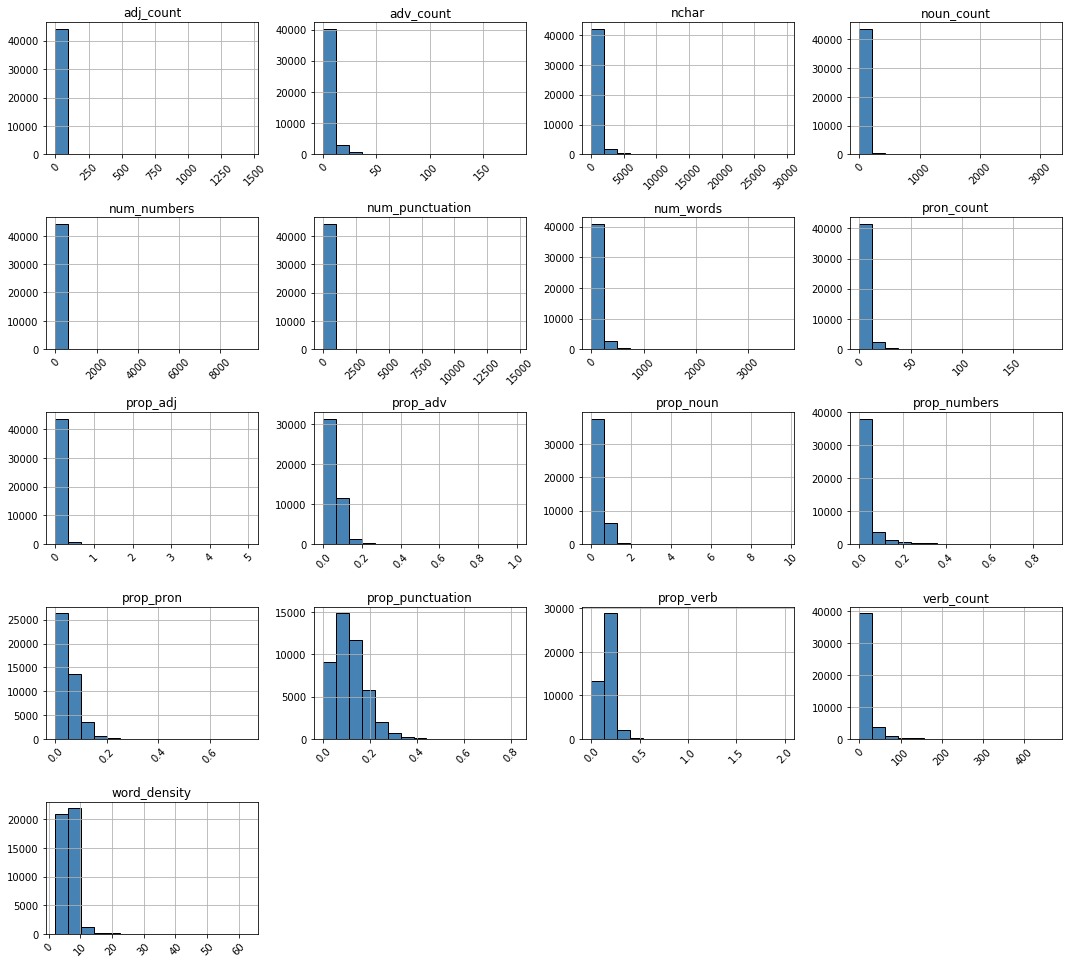

In [15]:
fig = train[variables[:-1]].hist(bins=15,
                 color='steelblue',
                 edgecolor='black', linewidth=1.0,
                 xlabelsize=10, ylabelsize=10,
                 xrot=45, yrot=0,
                 figsize=(10,9),
                 grid=True)

plt.tight_layout(rect=(0, 0, 1.5, 1.5))  

In [16]:
train[(train.prop_verb == 2) | (train.prop_noun > 1)].head(10)

,Comment,Outcome,Id,num_numbers,prop_numbers,num_words,num_punctuation,prop_punctuation,nchar,word_density,...,verb_count,adj_count,adv_count,pron_count,lda,prop_noun,prop_verb,prop_adj,prop_adv,prop_pron
44,the following code has served me well. customi...,1,17319,28,0.018945,114,275,0.186062,1478,12.852174,...,21,18,5,6,[2.24215250e-04 2.24215250e-04 1.94953923e-02 ...,1.122807,0.184211,0.157895,0.043860,0.052632
64,"simple way: subset( d, name %in% intersect(nam...",1,12004,8,0.100000,9,17,0.212500,80,8.000000,...,0,2,0,0,[0.00384615 0.19250324 0.00384615 0.00384615 0...,1.555556,0.000000,0.222222,0.000000,0.000000
66,the effects package has good ploting methods f...,1,45348,12,0.033898,23,66,0.186441,354,14.750000,...,6,5,0,0,[0.001 0.001 0.001 0.001 0...,1.391304,0.260870,0.217391,0.000000,0.000000
88,> summary(assayaov)[1][[1]][[1]][[3]] [1] 15.4...,1,6785,21,0.221053,8,40,0.421053,95,10.555556,...,10,2,0,0,[0.00625 0.00625 0.00625 0.00625 0.00625 0.006...,3.250000,1.250000,0.250000,0.000000,0.000000
138,"library(plyr) ddply(tbl, .(category), summaris...",1,25345,0,0.000000,7,13,0.185714,70,8.750000,...,0,1,0,0,[0.005 0.005 0.005 0.005 0...,1.285714,0.000000,0.142857,0.000000,0.000000
146,"expr[expr$cell_type == ""hesc"", ] expr[expr$cel...",1,40673,0,0.000000,10,23,0.264368,87,7.909091,...,2,1,1,0,[0.30559481 0.00416667 0.00416667 0.00416667 0...,1.200000,0.200000,0.100000,0.100000,0.000000
150,"> x<-c('1','2','3','4') > combn(x,2) [,1] [,2]...",1,14196,25,0.201613,24,68,0.548387,124,4.960000,...,3,2,0,0,[0.025 0.025 0.025 0.025 0.525 0.025 0.025 0.0...,1.125000,0.125000,0.083333,0.000000,0.000000
190,using alpha transparency: x <- seq(as.posixct(...,1,2815,69,0.091877,70,195,0.259654,751,10.577465,...,2,20,0,0,[4.50450452e-04 4.50450465e-04 4.50450450e-04 ...,1.200000,0.028571,0.285714,0.000000,0.000000
208,"what about this one x[order(match(x,y))]",1,28727,0,0.000000,5,7,0.175000,40,6.666667,...,0,0,0,1,[0.00714286 0.00714286 0.00714286 0.00714286 0...,1.400000,0.000000,0.000000,0.000000,0.200000
255,"the binwidth is measured in seconds, so to bin...",1,37547,56,0.130233,36,95,0.220930,430,11.621622,...,7,2,1,0,[0.00070423 0.00070423 0.00070423 0.00070423 0...,1.055556,0.194444,0.055556,0.027778,0.000000


I thought it was strange how there were proportions more than 1. I realised this was due to the fact that these were due to the noise from code since we split using spaces, but I thought this was useful information to have as well. Next, we visualise the correlations

In [17]:
corr = train[['num_numbers', 'noun_count', 'verb_count', 'pron_count', 'num_words', 'num_punctuation', 'adj_count', 'adv_count', 'nchar',
 'prop_punctuation', 'prop_numbers', 'prop_noun', 'word_density', 'prop_verb',
 'prop_adj', 'prop_adv', 'prop_pron', 'Outcome']].corr()
corr

,num_numbers,noun_count,verb_count,pron_count,num_words,num_punctuation,adj_count,adv_count,nchar,prop_punctuation,prop_numbers,prop_noun,word_density,prop_verb,prop_adj,prop_adv,prop_pron,Outcome
num_numbers,1.000000,0.422031,0.211871,0.093176,0.420102,0.579088,0.528946,0.172709,0.473027,0.119182,0.514050,0.037894,0.096295,-0.142101,0.057243,-0.075343,-0.118097,0.021307
noun_count,0.422031,1.000000,0.797550,0.559663,0.875670,0.799251,0.801514,0.672342,0.927762,0.100658,0.102054,0.104798,0.088907,-0.111360,0.051020,-0.052526,-0.146543,0.135210
verb_count,0.211871,0.797550,1.000000,0.833128,0.930933,0.520995,0.732585,0.895695,0.892189,-0.161662,-0.031862,-0.162742,-0.072801,0.115343,-0.045354,0.084461,0.001002,0.178196
pron_count,0.093176,0.559663,0.833128,1.000000,0.750237,0.323261,0.523949,0.812287,0.692032,-0.234661,-0.098738,-0.222084,-0.104115,0.106080,-0.102945,0.130317,0.288119,0.152209
num_words,0.420102,0.875670,0.930933,0.750237,1.000000,0.649733,0.846752,0.854564,0.960330,-0.075613,0.092623,-0.120536,-0.063747,-0.056638,-0.013165,0.024093,-0.076503,0.176539
num_punctuation,0.579088,0.799251,0.520995,0.323261,0.649733,1.000000,0.741151,0.423360,0.781865,0.228846,0.171713,0.127201,0.172491,-0.119000,0.096624,-0.067023,-0.134579,0.080380
adj_count,0.528946,0.801514,0.732585,0.523949,0.846752,0.741151,1.000000,0.657598,0.873647,0.031103,0.113907,-0.031409,0.029016,-0.088234,0.187725,-0.015325,-0.120463,0.132362
adv_count,0.172709,0.672342,0.895695,0.812287,0.854564,0.423360,0.657598,1.000000,0.799173,-0.192428,-0.048916,-0.194754,-0.090870,0.050096,-0.052675,0.287988,0.020544,0.182679
nchar,0.473027,0.927762,0.892189,0.692032,0.960330,0.781865,0.873647,0.799173,1.000000,-0.025924,0.091225,-0.046108,0.065133,-0.059769,0.024245,0.009338,-0.087041,0.165678
prop_punctuation,0.119182,0.100658,-0.161662,-0.234661,-0.075613,0.228846,0.031103,-0.192428,-0.025924,1.000000,0.337332,0.646657,0.321026,-0.291473,0.312908,-0.263458,-0.313079,-0.033055


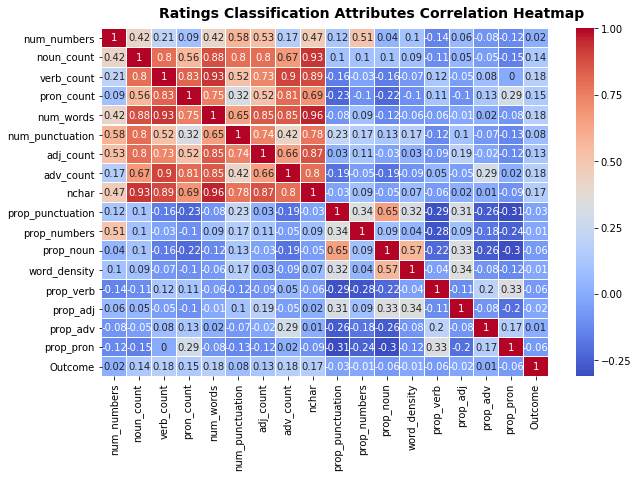

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

hm = sns.heatmap(round(corr,2), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 #annot_kws={"size": 14},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)

t = fig.suptitle('Ratings Classification Attributes Correlation Heatmap', fontsize=14, fontweight='bold')

#### As expected, we see high amounts of correaltion between the count of words with the variable Outcome. More words means it's a better answer and the other variables of "count" somehow include this information. We further explore the usefulness of using count versus proportions below. Given that my intention was to use tree based algoriths, LGBM and Catboost, normalisation was not much of a worry and my focus was just to determine if count or proportion was a better metric. Given num words and count of each adv, noun etc, this would already in a way, capture the proportion of these variables.

### LGBM Without proportion variables

In [19]:
from lightgbm import LGBMClassifier
X_train, X_val, y_train, y_val = train_test_split(train[[v for v in variables if "prop_" not in v][:-1]], train.Outcome, random_state=1, test_size=0.2)
LG = LGBMClassifier(random_state=1)
LG.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Train
Accuracy:  0.6773694717012961
Auroc:  0.7416834667984035
Validation
Accuracy:  0.6126855600539811
Auroc:  0.6603467157938832


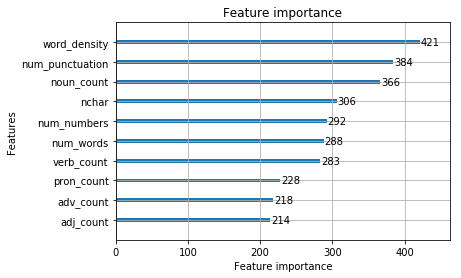

In [20]:
from sklearn import metrics
print("Train")
y_pred_class = LG.predict(X_train)
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class))

# Use predict proba for AUC
y_pred_class = LG.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class[:, 1]))

print("Validation")
y_pred_class = LG.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class))

# Use predict proba for AUC
y_pred_class_lgbm = LG.predict_proba(X_val)[:, 1]
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class_lgbm))

plot_importance(LG)

### LGBM With Proportion Variables

Train
Accuracy:  0.6881941125200326
Auroc:  0.7565272325570059
Validation
Accuracy:  0.6212325686009896
Auroc:  0.6624717032025006


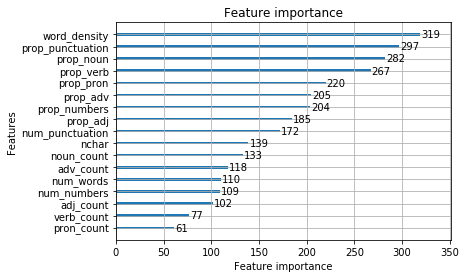

In [21]:
X_train, X_val, y_train, y_val = train_test_split(train[variables[:-1]], train.Outcome, random_state=1, test_size=0.2)
LG = LGBMClassifier(random_state=1)
LG.fit(X_train, y_train)

from sklearn import metrics
print("Train")
y_pred_class = LG.predict(X_train)
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class))
y_pred_class = LG.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class[:, 1]))

print("Validation")
y_pred_class = LG.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class))
y_pred_class_lgbm = LG.predict_proba(X_val)[:, 1]
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class_lgbm))

plot_importance(LG)

#### We do see a minor increase in the performance when including proportions and these are also one of the highest predictors. However, I wanted to conduct text analysis together with these variables to see if they really do boost performance. If not, I would rather lessen the number of variables used.

# Text Analysis

In [22]:
import warnings
# Ignore scipy warnings as it was intended to convert to sparse matrix below
warnings.filterwarnings("ignore", message="Converting data to scipy sparse matrix.")

In [23]:
# Helper function to get train, val and test data
def get_train_test(train, ngram_range = (1,1), add_vars = False, use_new = False, max_features=None, 
                   random_state=1, test_size=0.2, min_df=1):
    
    '''
    This is meant to prepare the train and test data, and we are able to vary the ngram range, min_df, randomtest, testsize
    and min df that goes into train test split and tfidf vectorizer.
    
    add_vars is a boolean to add the numerical features to the text dataset or not
    use_new is a boolean to use the newly created proportion metrics or not
    '''
    
    # Selecting desired columns
    X = train.Comment
    y = train.Outcome

    # split into train and test set, using random_state so that it is reproducable
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=random_state, test_size=test_size)

    # We use tfidf character level analyser
    tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=ngram_range, max_features=max_features, min_df=min_df)

    print("Fitting...")
    start = time.time()
    # Fit transform only on the train set, use it to transform the val set
    X_train_dtm =  tfidf_vect_ngram_chars.fit_transform(X_train) 
    X_val_dtm =  tfidf_vect_ngram_chars.transform(X_val) 
    print(f"Operation Took {round(start-time.time(), 2)}s")
    print(X_train_dtm.shape, X_val_dtm.shape)

    if add_vars:
        if use_new:
            # With proportions included
            additional_vars = ['num_numbers', 'noun_count', 'verb_count', 'pron_count', 'num_words', 'num_punctuation', 'adj_count', 'adv_count', 'nchar',
                 'prop_punctuation', 'prop_numbers', 'prop_noun', 'word_density', 'prop_verb',
                 'prop_adj', 'prop_adv', 'prop_pron']
        else: 
            additional_vars = ['num_numbers', 'prop_numbers', 'num_words',
               'num_punctuation', 'prop_punctuation', 'nchar', 'word_density', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']
        # Next, we need to add in the other variables from EDA, need to use scipy to maintain the sparse matrix or we will run out of memory
        add_var_df = train.loc[X_train.index].reset_index()[additional_vars]

        for column in add_var_df.columns:
            var_sparse = add_var_df[column].values[:, None]
            # Stacks horizontally, effectively increasing columns of features to include our EDA
            X_train_dtm = hstack((X_train_dtm, var_sparse))

        # Repeat the same for the validation set
        add_var_df = train.loc[X_val.index].reset_index()[additional_vars]
        for column in add_var_df.columns:
            var_sparse = add_var_df[column].values[:, None]
            X_val_dtm = hstack((X_val_dtm, var_sparse))
    
    print("X_train: ", X_train_dtm.shape)
    print("X_val: ", X_val_dtm.shape)

    return X_train_dtm, X_val_dtm, y_train, y_val, tfidf_vect_ngram_chars

# Vectorizer Alone

In [24]:
X_train_dtm, X_val_dtm, y_train, y_val, tfidf_vect_ngram_chars= get_train_test(train = train, 
        min_df = 10, test_size = 0.1, random_state = 1, ngram_range = (1,2))
# We use min_df of 10, test size and random state will not be changed so as to isolate improvements solely to variables

Fitting...
Operation Took -42.06s
(40013, 3974) (4446, 3974)
X_train:  (40013, 3974)
X_val:  (4446, 3974)


In [25]:
LG = LGBMClassifier(random_state=1, class_weight='balanced')
LG.fit(X_train_dtm, y_train)

from sklearn import metrics
print("Train")
y_pred_class = LG.predict(X_train_dtm)
# Comparison between vanilla roc_auc using predict vs if we use predict_proba
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class))
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))
y_pred_class = LG.predict_proba(X_train_dtm)[:, 1]
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))

print("Validation")
y_pred_class = LG.predict(X_val_dtm)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class))
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))
y_pred_class_lgbm = LG.predict_proba(X_val_dtm)[:, 1]
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class_lgbm))

Train
Accuracy:  0.7913428135855847
Auroc:  0.7934068218154706
Auroc:  0.8775541206194791
Validation
Accuracy:  0.710076473234368
Auroc:  0.7099930184222704
Auroc:  0.7868581727361261


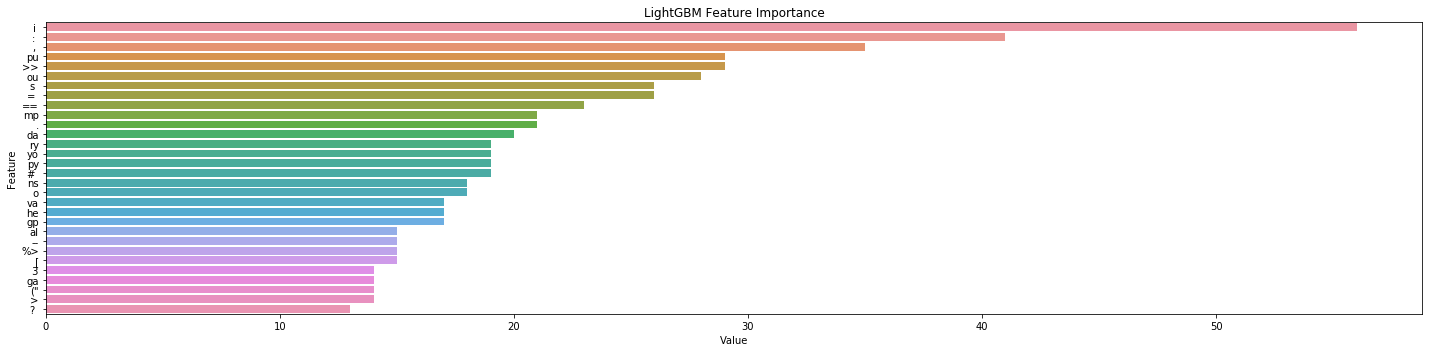

In [26]:
features = tfidf_vect_ngram_chars.get_feature_names()
feat_impt = LG.feature_importances_

warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(feat_impt,features)), columns=['Value','Feature']).iloc[-30:]

plt.figure(figsize=(20, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

#### Here, we see that the punctuations used have very high predictive power! This ngram range is also able to capture short words. We may want to use a wider range to capture more words in future iterations. I explore using a wider range in path "Jupyter Notebooks\Hyperparameter Tuning", and tune vectorizer to use as well as other text preprocessing hyperparameters.

# Vectorizer with Initial Features

In [27]:
X_train_dtm, X_val_dtm, y_train, y_val, tfidf_vect_ngram_chars = get_train_test(train = train, min_df = 10, test_size = 0.1, 
                                                        random_state = 1, add_vars = True, ngram_range = (1,2))

LG = LGBMClassifier(random_state=1, class_weight='balanced')
LG.fit(X_train_dtm, y_train)

from sklearn import metrics
print("Train")
y_pred_class = LG.predict(X_train_dtm)
# Comparison between vanilla roc_auc using predict vs if we use predict_proba
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class))
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))
y_pred_class = LG.predict_proba(X_train_dtm)[:, 1]
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))

print("Validation")
y_pred_class = LG.predict(X_val_dtm)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class))
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))
y_pred_class_lgbm = LG.predict_proba(X_val_dtm)[:, 1]
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class_lgbm))

Fitting...
Operation Took -42.74s
(40013, 3974) (4446, 3974)
X_train:  (40013, 3986)
X_val:  (4446, 3986)
Train
Accuracy:  0.7931922125309274
Auroc:  0.7952093601277527
Auroc:  0.8790047904512805
Validation
Accuracy:  0.7078272604588394
Auroc:  0.707470555664039
Auroc:  0.7857606267411505


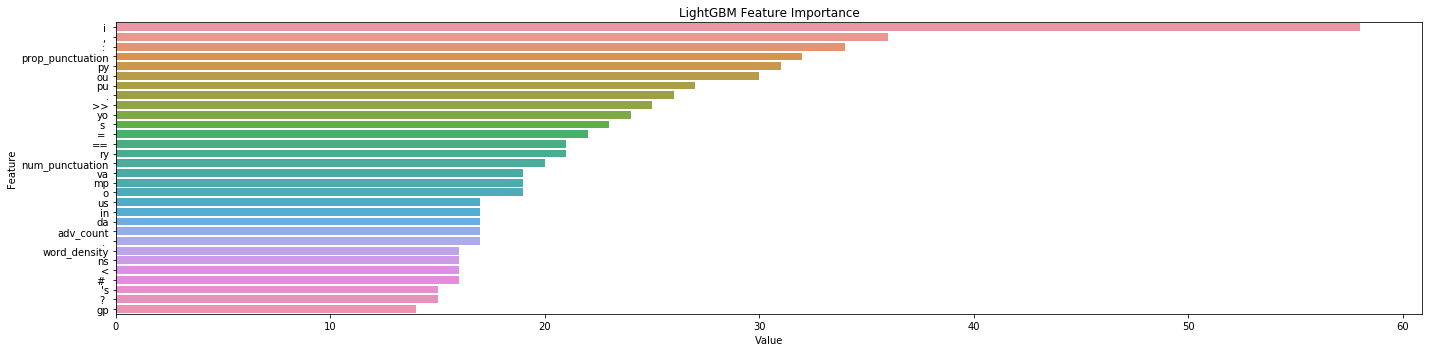

In [28]:
features = tfidf_vect_ngram_chars.get_feature_names() + ['num_numbers', 'prop_numbers', 'num_words', 'num_punctuation', 'prop_punctuation', 
    'nchar', 'word_density', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']
feat_impt = LG.feature_importances_

warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(feat_impt,features)), columns=['Value','Feature']).iloc[-30:]

plt.figure(figsize=(20, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

#### Interesting, prop_punctuation, word density and num puctuations are good variables with adv_count doing well! This follows my initial intuition that adv, adj, noun, pronoun and verbs may not have high predictability power, but rather punctuations and density of words that capture code, as well as complex language used. This was a small improvement of 0.001, but looking at other kaggle competitions, this 0.001 can be significant and decide final rankings.

# Vectorizer With All Features

In [29]:
X_train_dtm, X_val_dtm, y_train, y_val, tfidf_vect_ngram_chars = get_train_test(train = train, min_df = 10, test_size = 0.1, 
                                                        random_state = 1, add_vars = True, use_new=True, ngram_range = (1,2))

LG = LGBMClassifier(random_state=1, class_weight='balanced')
LG.fit(X_train_dtm, y_train)

from sklearn import metrics
print("Train")
y_pred_class = LG.predict(X_train_dtm)
# Comparison between vanilla roc_auc using predict vs if we use predict_proba
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class))
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))
y_pred_class = LG.predict_proba(X_train_dtm)[:, 1]
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))

print("Validation")
y_pred_class = LG.predict(X_val_dtm)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class))
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))
y_pred_class_lgbm = LG.predict_proba(X_val_dtm)[:, 1]
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class_lgbm))

Fitting...
Operation Took -39.45s
(40013, 3974) (4446, 3974)
X_train:  (40013, 3991)
X_val:  (4446, 3991)
Train
Accuracy:  0.7934671231849649
Auroc:  0.795211795577014
Auroc:  0.8791460541231806
Validation
Accuracy:  0.7103013945119209
Auroc:  0.7101334524570606
Auroc:  0.7856659752305226


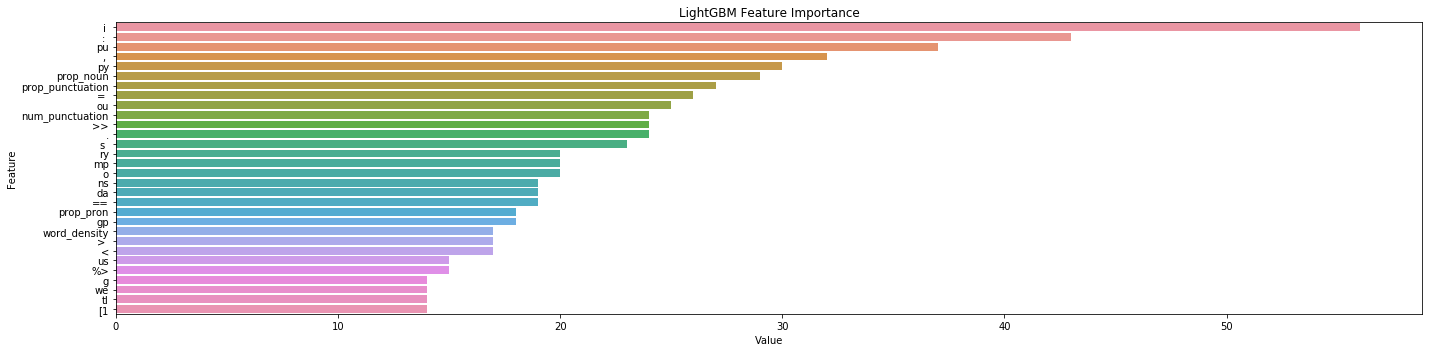

In [30]:
features = tfidf_vect_ngram_chars.get_feature_names() + ['num_numbers', 'noun_count', 'verb_count', 
    'pron_count', 'num_words', 'num_punctuation', 'adj_count', 'adv_count', 'nchar', 'prop_punctuation', 
    'prop_numbers', 'prop_noun', 'word_density', 'prop_verb', 'prop_adj', 'prop_adv', 'prop_pron']
feat_impt = LG.feature_importances_

warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(feat_impt,features)), columns=['Value','Feature']).iloc[-30:]

plt.figure(figsize=(20, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

#### The val score has decreased slightly from 0.78576 to 0.78566, which is not much different! I decided to just use the "count" of each pos tag since we have similar results (even worse when we added in the proportions). I was intending to use these variables for tree based algorithms and my intuition is that this information is already captured once we have "num_words" together with the "count".

#### With this, I concluded my exploratory data analysis, having decided what variables to use and gaining intuition of the data.